# VAE

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE

## 学習データ作成

In [9]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, test_data , anomaly_data= Dataset.read_traindata("sample_data", "sample_test", 3000, 256, 1)


(500, 256)
(500, 256)
----------------------
(100, 256)
(100, 256)
----------------------
(100, 256)
100
----------------------
(500, 256)
(100, 256)
1148 0
rate 0.9
data.shape[0]: 500
rate 450
TrainData (3000, 256, 1, 1, 256)
TestData (50, 256)
ÄnomalyDta (100, 256)


## モデル作成

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008)

In [10]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

## モデル作成

## モデル学習

In [11]:
#netよう
z_dim = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modelVAE.VAE_cnn_drop_net(z_dim, device).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
input_data = torch.from_numpy(data.astype(np.float32)).clone()
input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()

model.train()
loss_list = []
cnt = 0
# input_data = input_data[0:300]
for epoch in input_data:
    losses = []
    cnt += 1
    for x in epoch:
        x = x.to(device) # データをGPUにのせる
        loss, z, y = model(x, device) # 損失関数の値 loss 、潜在ベクトル z 、再構築画像 y を出力
        model.zero_grad() # モデルの勾配を初期化
        loss.backward() # モデル内のパラメータの勾配を計算
        optimizer.step() # 最適化を実行
        losses.append(loss.cpu().detach().numpy()) # ミニバッチの損失を記録
    loss_list.append(np.average(losses)) # バッチ全体の損失を登録
    print("EPOCH: {} loss: {}".format(cnt, np.average(losses)))
    # for x in input_test_data:
    #     KL_loss, reconstruction_loss = model.loss(x)
    #     loss = KL_loss + reconstruction_loss
    #     losses_val.append(loss.cpu().detach().numpy())

    # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
    #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

EPOCH: 1 loss: 164.8006591796875
EPOCH: 2 loss: 115.99036407470703
EPOCH: 3 loss: 91.28346252441406
EPOCH: 4 loss: 83.23204040527344
EPOCH: 5 loss: 83.0858154296875
EPOCH: 6 loss: 76.98025512695312
EPOCH: 7 loss: 76.81134033203125
EPOCH: 8 loss: 81.70805358886719
EPOCH: 9 loss: 79.20120239257812
EPOCH: 10 loss: 79.47208404541016
EPOCH: 11 loss: 73.86711120605469
EPOCH: 12 loss: 79.25016784667969
EPOCH: 13 loss: 78.75151824951172
EPOCH: 14 loss: 81.24766540527344
EPOCH: 15 loss: 76.81206512451172
EPOCH: 16 loss: 76.24421691894531
EPOCH: 17 loss: 75.39605712890625
EPOCH: 18 loss: 75.2925033569336
EPOCH: 19 loss: 79.5721664428711
EPOCH: 20 loss: 78.19879913330078
EPOCH: 21 loss: 76.9222640991211
EPOCH: 22 loss: 80.37966918945312
EPOCH: 23 loss: 77.15892028808594
EPOCH: 24 loss: 73.2613525390625
EPOCH: 25 loss: 77.57959747314453
EPOCH: 26 loss: 76.47280883789062
EPOCH: 27 loss: 81.32429504394531
EPOCH: 28 loss: 80.06482696533203
EPOCH: 29 loss: 75.47462463378906
EPOCH: 30 loss: 74.69124603

In [12]:
# z_dim = 8
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = modelVAE.VAE_cnn(z_dim, device).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
# input_data = torch.from_numpy(data.astype(np.float32)).clone()
# input_test_data = torch.from_numpy(test_data.astype(np.float32)).clone()
# for epoch in input_data:
#     losses = []
#     KL_losses = []
#     reconstruction_losses = []
#     model.train()
#     for x in epoch:
#         x = x.to(device)
#         model.zero_grad()
#         KL_loss, reconstruction_loss = model.loss(x)  # lossの各項の計算
#         loss = KL_loss + reconstruction_loss  # 和を取ってlossとする
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.detach().numpy())
#         KL_losses.append(KL_loss.detach().numpy())
#         reconstruction_losses.append(reconstruction_loss.detach().numpy())

#     losses_val = []
#     model.eval()
#     # for x in input_test_data:
#     #     KL_loss, reconstruction_loss = model.loss(x)
#     #     loss = KL_loss + reconstruction_loss
#     #     losses_val.append(loss.cpu().detach().numpy())

#     # print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
#     #     (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses)))

## モデルの保存

In [13]:
# model_name = "vaemodel"
# ModelEdit = mainmodel.Modeledit("syuron")
# ModelEdit.save_model(model, model_name) 

## 確認だよーん

tensor([[[0.1646, 0.1646, 0.1646, 0.1646, 0.1646, 0.1646, 0.1646, 0.1646,
          0.1646, 0.1646, 0.1646, 0.1646, 0.1646, 0.1646, 0.0958, 0.0873,
          0.0563, 0.0571, 0.0579, 0.0622, 0.0635, 0.0738, 0.0745, 0.0753,
          0.0555, 0.0530, 0.0451, 0.0458, 0.0467, 0.0335, 0.0320, 0.0279,
          0.0285, 0.0292, 0.0279, 0.0280, 0.0318, 0.0325, 0.0332, 0.0361,
          0.0370, 0.0457, 0.0464, 0.0472, 0.0367, 0.0356, 0.0330, 0.0337,
          0.0344, 0.0326, 0.0327, 0.0362, 0.0369, 0.0377, 0.0426, 0.0439,
          0.0552, 0.0559, 0.0568, 0.0433, 0.0418, 0.0375, 0.0382, 0.0390,
          0.0375, 0.0376, 0.0417, 0.0424, 0.0432, 0.0466, 0.0476, 0.0570,
          0.0578, 0.0586, 0.0721, 0.0752, 0.0964, 0.0970, 0.0977, 0.0890,
          0.0880, 0.0860, 0.0867, 0.0875, 0.1185, 0.1250, 0.1646, 0.1646,
          0.1646, 0.1309, 0.1259, 0.1051, 0.1057, 0.1063, 0.1095, 0.1104,
          0.1175, 0.1179, 0.1185, 0.1045, 0.1025, 0.0960, 0.0966, 0.0973,
          0.1080, 0.1103, 0.1250, 0.12

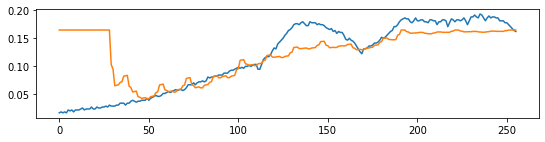

normal:8.154366966336966


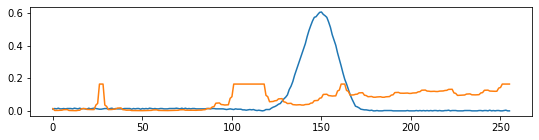

anomarly:25.450477202888578
anomaly
<class 'torch.Tensor'>


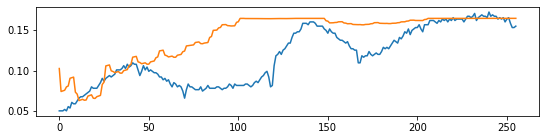

normal:6.790502585470676


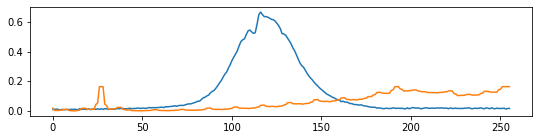

anomarly:34.56426686793566
anomaly
<class 'torch.Tensor'>


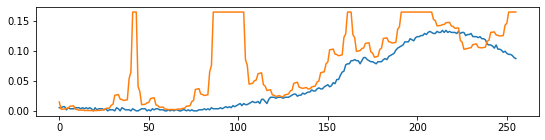

normal:8.502057692268863


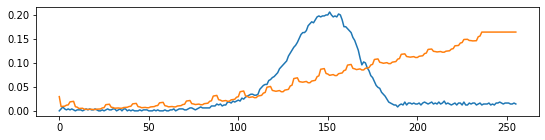

anomarly:14.70359620358795
anomaly
<class 'torch.Tensor'>


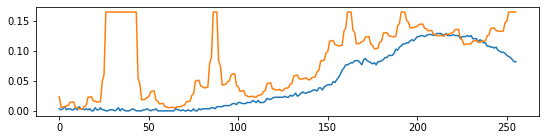

normal:9.555932446848601


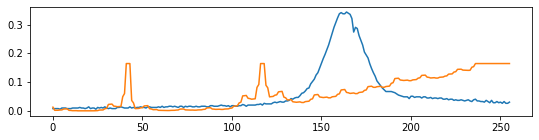

anomarly:15.485382898943499
anomaly
<class 'torch.Tensor'>


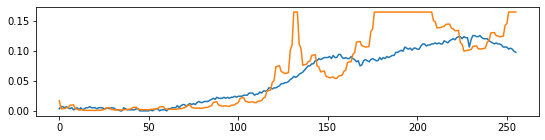

normal:5.611899628769606


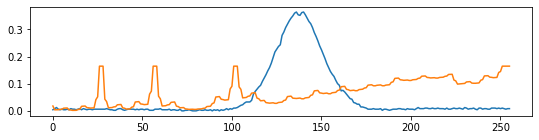

anomarly:21.324909140355885
anomaly


IndexError: index 50 is out of bounds for axis 0 with size 50

In [14]:
# num = 5
data0 =  torch.from_numpy((test_data[0]).astype(np.float32)).clone()
data0 = data0[np.newaxis, np.newaxis, :]
loss, z, recon = model(data0, device)
# recon, _ = model(data0)
recon = recon.detach()
print(recon)

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        input_data = data0[np.newaxis, np.newaxis, :]
        # recon,_ = model(input_data)
        loss, z, recon = model(input_data, device)
        recon = recon.detach().numpy()
        plt.plot(data0.numpy())
        plt.plot(recon.flatten())
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-data0.numpy()))
        print("normal:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")
            
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        input_data = test0[np.newaxis, np.newaxis, :]
        # recon,_ = model(input_data)
        loss, z, recon = model(input_data, device)
        recon = recon.detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>10):
            print("anomaly")

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols=5, figsize=(20,12))
model.eval()
for r in range(3):
    for c in range(5):
        ax[r,c].imshow(model.decoder(torch.randn(10).cuda()).detach().cpu().numpy().reshape(28,28), cmap="gray")
        ax[r,c].axis("off")